## 1. Usual pre-amble and loading data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import os
import time
from collections import defaultdict
from PIL import Image
from matplotlib.pyplot import imsave

import facenet
import lfw
import foolbox

import mp # previous Jupyter notebook

In [2]:
with open('full_results', 'rb') as f:
    results = pickle.load(f)

In [3]:
results['gaussian_noise'] = results['guassian_noise']

In [4]:
tf.Graph().as_default()
sess = tf.Session()
# Load model
model = mp.InceptionResnetV1Model()
# Convert to classifier
model.convert_to_classifier()

# Load pairs of faces and their labels in one-hot encoding
size = 100
faces1, faces2, labels = mp.load_testset(size)
binary_labels = [0 if labels[i][0] == 1 else 1 for i in range(size)]

# Create victims' embeddings using Facenet itself
graph = tf.get_default_graph()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
feed_dict = {model.face_input: faces2,
              phase_train_placeholder: False}
victims_embeddings = sess.run(
    model.embedding_output, feed_dict=feed_dict)
feed_dict = {model.face_input: faces1,
              phase_train_placeholder: False}
non_victims_embeddings = sess.run(
  model.embedding_output, feed_dict=feed_dict)

sess.close()

Model filename: ../models/20180402-114759/20180402-114759.pb


In [5]:
binary_labels = np.array(binary_labels[:50])
anonymization_total = np.sum(binary_labels == 0)
impersonation_total = np.sum(binary_labels == 1)

print(anonymization_total)
print(impersonation_total)

26
24


## 2. Analysis of attacks on undefended network

In [6]:
def analyze_results(attack_type, threshold=float('inf')):
    changed = results[attack_type]['changed']

    anonymization_successful = 0
    impersonation_successful = 0
    anonymization_deltas = []
    impersonation_deltas = []

    for i in range(len(changed)):
      success = (changed[i] is not None) and (changed[i] < threshold)
      if (success):
        anonymization_successful += (binary_labels[i] == 0)
        impersonation_successful += (binary_labels[i] == 1)
        if (binary_labels[i] == 0):
          anonymization_deltas.append(changed[i])
        if (binary_labels[i] == 1):
          impersonation_deltas.append(changed[i])

    print("Anonymization Success Rate: ", anonymization_successful / anonymization_total)
    print("Impersonation Success Rate: ", impersonation_successful / impersonation_total)

    print("Average L2Norm(Delta) (Anonymization): ", np.mean(anonymization_deltas))
    print("Average L2Norm(Delta) (Impersonation): ", np.mean(impersonation_deltas))

In [24]:
print("FGSM:")
analyze_results('fgsm')

FGSM:
Anonymization Success Rate:  1.0
Impersonation Success Rate:  0.7916666666666666
Average L2Norm(Delta) (Anonymization):  1.2299692412246641
Average L2Norm(Delta) (Impersonation):  2.4087448145863966


In [16]:
print("DeepFool:")
analyze_results('deep_fool')

DeepFool:
Anonymization Success Rate:  1.0
Impersonation Success Rate:  1.0
Average L2Norm(Delta) (Anonymization):  0.5046945956565858
Average L2Norm(Delta) (Impersonation):  0.9038222545173058


In [22]:
print("Uniform Noise: ")
analyze_results('uniform_noise')

Uniform Noise: 
Anonymization Success Rate:  1.0
Impersonation Success Rate:  0.0
Average L2Norm(Delta) (Anonymization):  33.2933691543952
Average L2Norm(Delta) (Impersonation):  nan


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
print("Gaussian Noise: ")
analyze_results('gaussian_noise')

Gaussian Noise: 
Anonymization Success Rate:  1.0
Impersonation Success Rate:  0.041666666666666664
Average L2Norm(Delta) (Anonymization):  32.78866529339295
Average L2Norm(Delta) (Impersonation):  12.914182036742726


## 3. Investigating mean filter

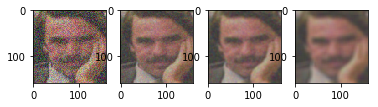

In [36]:
# First thing to try is a mean filter to "average out" noise

img = results['uniform_noise']['adversarials'][0]
plt.subplot(1, 4, 1)
plt.imshow(img)

avgd3 = cv2.blur(img,(3,3)) # 3x3 mean filter
plt.subplot(1, 4, 2)
plt.imshow(avgd3)

avgd5 = cv2.blur(img,(5,5)) # 3x3 mean filter
plt.subplot(1, 4, 3)
plt.imshow(avgd5)

avgd10 = cv2.blur(img,(10,10)) # 3x3 mean filter
plt.subplot(1, 4, 4)
plt.imshow(avgd10)

In [30]:
graph = tf.get_default_graph()
i = 0
sess = tf.Session()
model = mp.InceptionResnetV1Model()
model.convert_to_targeted_classifier(victims_embeddings[i])
model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                          {phase_train_placeholder: False})
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

Model filename: ../models/20180402-114759/20180402-114759.pb


In [40]:
model_fb.forward(np.array([results['uniform_noise']['adversarials'][0]])).argmax(axis=-1)

array([1])

In [41]:
model_fb.forward(np.array([avgd3])).argmax(axis=-1)

array([0])

In [42]:
model_fb.forward(np.array([avgd5])).argmax(axis=-1)

array([0])

In [43]:
model_fb.forward(np.array([avgd10])).argmax(axis=-1)

array([0])

In [31]:
# So all 3 mean filters have correctly defended against the adversarial example!
# Now let's see how this works in aggregate.

tf.reset_default_graph()

## 4. Tuning of Hyperparameter (mean filter size & error analysis)

In [32]:
sess = tf.Session()
model = mp.InceptionResnetV1Model()
model.convert_to_classifier()
graph = tf.get_default_graph()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
batch_size = graph.get_tensor_by_name("batch_size:0")

Model filename: ../models/20180402-114759/20180402-114759.pb


In [43]:
def run_mean_filter_defense_for_example(i, attack_type, filter_size):
    adversarial = results[attack_type]['adversarials'][i]
        
    # nothing to correct because attack was not successful
    if (adversarial is None):
        return {
            'diff': None,
            'corrected': True,
        }
        
    avgd = cv2.blur(adversarial,(filter_size, filter_size)) # 3x3 mean filter

    feed_dict = {model.face_input: np.array([avgd]),
                 model.victim_embedding_input: victims_embeddings[i:i+1],
                 phase_train_placeholder: False,
                 batch_size: 1}
    new_prediction = sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)[0]
    
    diff = np.linalg.norm(avgd - faces1[i])
    
    return {
        'diff': diff,
        'corrected': (new_prediction == binary_labels[i])
    }

In [44]:
def run_mean_filter_defense(attack_type, filter_size):
    anonymization_successful = 0
    impersonation_successful = 0
    anonymization_deltas = []
    impersonation_deltas = []
    
    for i in range(50):
        res = run_mean_filter_defense_for_example(i, attack_type, filter_size)
        success = (res['corrected'] == False)
        if (success):
            anonymization_successful += (binary_labels[i] == 0)
            impersonation_successful += (binary_labels[i] == 1)
            print("Unable to defend for example ", i)
        diff = res['diff']
        if (diff is not None):
            if binary_labels[i] == 0:
                anonymization_deltas.append(diff)
            else:
                impersonation_deltas.append(diff)
    
    print("Anonymization Attack Success Rate: ", anonymization_successful / anonymization_total)
    print("Impersonation Attack Success Rate: ", impersonation_successful / impersonation_total)
    
    print("Average L2Norm(Delta) (Anonymization): ", np.mean(anonymization_deltas))
    print("Average L2Norm(Delta) (Impersonation): ", np.mean(impersonation_deltas))

In [45]:
run_mean_filter_defense('uniform_noise', 3)

Unable to defend for example  1
Unable to defend for example  49
Anonymization Attack Success Rate:  0.07692307692307693
Impersonation Attack Success Rate:  0.0
Average L2Norm(Delta) (Anonymization):  11.50222388712999
Average L2Norm(Delta) (Impersonation):  nan


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [116]:
run_mean_filter_defense('uniform_noise', 5)

Unable to defend for example  1
Unable to defend for example  4
Unable to defend for example  32
Unable to defend for example  38
Unable to defend for example  49
Anonymization Attack Success Rate:  0.19230769230769232
Impersonation Attack Success Rate:  0.0
Average Reduction in Diff:  25.16340334485968


In [117]:
run_mean_filter_defense('uniform_noise', 10)

Unable to defend for example  2
Unable to defend for example  16
Unable to defend for example  22
Unable to defend for example  32
Unable to defend for example  36
Unable to defend for example  38
Unable to defend for example  39
Unable to defend for example  46
Unable to defend for example  47
Unable to defend for example  49
Anonymization Attack Success Rate:  0.38461538461538464
Impersonation Attack Success Rate:  0.0
Average Reduction in Diff:  23.914765262918106


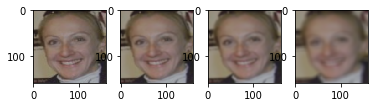

In [118]:
# Error analysis for 3x3 filter case

img = results['uniform_noise']['adversarials'][1]
plt.subplot(1, 4, 1)
plt.imshow(img)

avgd3 = cv2.blur(img,(3,3)) # 3x3 mean filter
plt.subplot(1, 4, 2)
plt.imshow(avgd3)

avgd5 = cv2.blur(img,(5,5)) # 3x3 mean filter
plt.subplot(1, 4, 3)
plt.imshow(avgd5)

avgd10 = cv2.blur(img,(10,10)) # 3x3 mean filter
plt.subplot(1, 4, 4)
plt.imshow(avgd10)

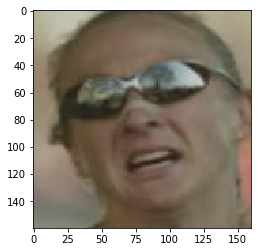

In [119]:
plt.imshow(faces2[1])

In [124]:
feed_dict = {model.face_input: np.array([faces1[1]]),
                 model.victim_embedding_input: victims_embeddings[1:2],
                 phase_train_placeholder: False,
                 batch_size: 1}
sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)

array([1])

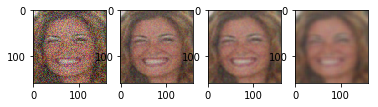

In [120]:
img = results['uniform_noise']['adversarials'][49]
plt.subplot(1, 4, 1)
plt.imshow(img)

avgd3 = cv2.blur(img,(3,3)) # 3x3 mean filter
plt.subplot(1, 4, 2)
plt.imshow(avgd3)

avgd5 = cv2.blur(img,(5,5)) # 3x3 mean filter
plt.subplot(1, 4, 3)
plt.imshow(avgd5)

avgd10 = cv2.blur(img,(10,10)) # 3x3 mean filter
plt.subplot(1, 4, 4)
plt.imshow(avgd10)

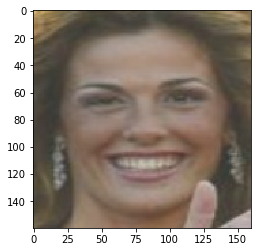

In [121]:
plt.imshow(faces2[49])

In [123]:
feed_dict = {model.face_input: np.array([faces1[49]]),
                 model.victim_embedding_input: victims_embeddings[49:50],
                 phase_train_placeholder: False,
                 batch_size: 1}
sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)

array([0])

In [125]:
# To summarize:
# 3x3 filter seems to work best which is also the suggestion of the Carlini-Wagner paper
# basically attacks with 0 knowledge go to 0% (the two  examples that are misclassified are just too hard)
# the first of the two missed examples is misclassified by facenet itself so defense cannot be expected to improve this

# Now let's see what this defense looks like for other attack images

## 5. Collecting Zero Knowledge Mean Filter Results

In [46]:
run_mean_filter_defense('gaussian_noise', 3)

Unable to defend for example  1
Unable to defend for example  32
Unable to defend for example  38
Anonymization Attack Success Rate:  0.11538461538461539
Impersonation Attack Success Rate:  0.0
Average L2Norm(Delta) (Anonymization):  11.340090747887814
Average L2Norm(Delta) (Impersonation):  4.376968627360934


In [47]:
run_mean_filter_defense('fgsm', 3)

Unable to defend for example  1
Unable to defend for example  32
Anonymization Attack Success Rate:  0.07692307692307693
Impersonation Attack Success Rate:  0.0
Average L2Norm(Delta) (Anonymization):  2.2022097567080854
Average L2Norm(Delta) (Impersonation):  2.382994972854819


In [48]:
run_mean_filter_defense('deep_fool', 3)

Unable to defend for example  1
Unable to defend for example  32
Anonymization Attack Success Rate:  0.07692307692307693
Impersonation Attack Success Rate:  0.0
Average L2Norm(Delta) (Anonymization):  2.0479358033415647
Average L2Norm(Delta) (Impersonation):  1.8830811841771606


In [129]:
# interesting to note that denoising actually moves the image farther away from the true image 
# but results in correct classification

In [ ]:
# Can a more advanced denoising algorithm do any better? (this is already pretty close to perfect)

## 6. Collect Zero Knowledge Noise2Clean defense results

Noise2Clean images generated in separate notebook due to compatibility issues in TensorFlow versions

In [21]:
min_pixel, max_pixel = mp.get_minmax(100)

In [10]:
min_pixel, max_pixel

(-3.1854634284973145, 4.514506816864014)

In [11]:
images = facenet.load_data(['./test/faces1-deepfool-n2n/1.png'], False, False, 160)

In [12]:
images = (images - min_pixel) / (max_pixel - min_pixel)

In [22]:
def run_n2n_defense_for_example(i, attack_type, dir_name):
    adversarial = results[attack_type]['adversarials'][i]
        
    # nothing to correct because attack was 
    if (adversarial is None):
        return {
            'reduction_in_diff': None,
            'corrected': True,
        }
        
    images = facenet.load_data(['./test/faces1-' + dir_name + '-n2n/' + str(i) + '.png'], False, False, 160)
    images = (images - min_pixel) / (max_pixel - min_pixel)
    avgd = images[0]
    
    feed_dict = {model.face_input: np.array([adversarial]),
                 model.victim_embedding_input: victims_embeddings[i:i+1],
                 phase_train_placeholder: False,
                 batch_size: 1}
    old_prediction = sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)[0]

    feed_dict = {model.face_input: np.array([avgd]),
                 model.victim_embedding_input: victims_embeddings[i:i+1],
                 phase_train_placeholder: False,
                 batch_size: 1}
    new_prediction = sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)[0]
    
    reduction_in_diff = np.linalg.norm(adversarial - faces1[i]) - np.linalg.norm(avgd - faces1[i])

    return {
        'reduction_in_diff': reduction_in_diff,
        'corrected': (old_prediction != new_prediction)
    }

In [23]:
def run_n2n_defense(attack_type, dir_name):
    anonymization_successful = 0
    impersonation_successful = 0
    reductions_in_diff = []
    
    for i in range(50):
        res = run_n2n_defense_for_example(i, attack_type, dir_name)
        success = (res['corrected'] == False)
        if (success):
            anonymization_successful += (binary_labels[i] == 0)
            impersonation_successful += (binary_labels[i] == 1)
            print("Unable to defend for example ", i)
        reduction = res['reduction_in_diff']
        if (reduction is not None):
            reductions_in_diff.append(reduction)
    
    print("Anonymization Attack Success Rate: ", anonymization_successful / anonymization_total)
    print("Impersonation Attack Success Rate: ", impersonation_successful / impersonation_total)

    print("Average Reduction in Diff: ", np.mean(reductions_in_diff))

In [24]:
run_n2n_defense('uniform_noise', 'uniform')

Unable to defend for example  1
Anonymization Attack Success Rate:  0.038461538461538464
Impersonation Attack Success Rate:  0.0
Average Reduction in Diff:  28.740193809420102


In [25]:
run_n2n_defense('gaussian_noise', 'gaussian')

Unable to defend for example  1
Unable to defend for example  32
Unable to defend for example  38
Anonymization Attack Success Rate:  0.11538461538461539
Impersonation Attack Success Rate:  0.0
Average Reduction in Diff:  27.637783991169293


In [26]:
run_n2n_defense('fgsm', 'fgsm')

Unable to defend for example  0
Unable to defend for example  1
Unable to defend for example  2
Unable to defend for example  3
Unable to defend for example  6
Unable to defend for example  9
Unable to defend for example  10
Unable to defend for example  13
Unable to defend for example  19
Unable to defend for example  20
Unable to defend for example  22
Unable to defend for example  23
Unable to defend for example  30
Unable to defend for example  31
Unable to defend for example  32
Unable to defend for example  34
Unable to defend for example  35
Unable to defend for example  36
Unable to defend for example  37
Unable to defend for example  38
Unable to defend for example  39
Unable to defend for example  40
Unable to defend for example  42
Unable to defend for example  43
Unable to defend for example  44
Unable to defend for example  47
Unable to defend for example  49
Anonymization Attack Success Rate:  0.6923076923076923
Impersonation Attack Success Rate:  0.375
Average Reduction 

In [27]:
run_n2n_defense('deep_fool', 'deepfool')

Unable to defend for example  1
Unable to defend for example  3
Unable to defend for example  16
Unable to defend for example  23
Unable to defend for example  30
Unable to defend for example  31
Unable to defend for example  34
Unable to defend for example  36
Unable to defend for example  41
Unable to defend for example  44
Unable to defend for example  46
Unable to defend for example  47
Unable to defend for example  48
Unable to defend for example  49
Anonymization Attack Success Rate:  0.34615384615384615
Impersonation Attack Success Rate:  0.20833333333333334
Average Reduction in Diff:  -0.11949403378826914


A couple interesting things to note:
1. Simple mean filter defense essentially eliminates all zero knowledge attacks.
2. More complex Noise2Clean defense works better at eliminating black-box attacks (further reductions in diff and only one successful attack).
3. Although Noise2Clean eliminates the majority of white-box attacks as well it is worse than mean filter defense at this. Likely this is a combination of: 1) our Noise2Clean model was pretrained to remove Gaussian noise and so will not work well for the DeepFool and FGSM attacks which do not generate this sort of noise; and 2) the perturbation generated by FGSM and DeepFool is so small that it is probably very difficult to perceive even for a NN.